https://theaisummer.com/unet-architectures/#u-net-and-3d-u-net

In [1]:
!pip install segmentation-models-pytorch
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset
SimpleOxfordPetDataset.download(".")
train_dataset = SimpleOxfordPetDataset(".", "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(".", "test")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5fab1efac07b33e255b7068f9e3ba886d07805db8656e66d659eef236a11c0f4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=d2bcbc07e7044ff3a5a306ac46a3611f6661e971d4b9177db5ea58ea919a6b8a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

images.tar.gz: 100%|██████████| 755M/755M [00:24<00:00, 32.0MB/s]
annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:02<00:00, 6.48MB/s]


In [2]:
import torch
import torchvision

In [3]:
test_dataset[0]["image"].shape

(3, 256, 256)

In [4]:
from torchvision import transforms
_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
import numpy as np
_transform(np.transpose(test_dataset[0]["image"],(1,2,0)))

tensor([[[-0.8039, -0.8353, -0.8431,  ...,  0.3804,  0.3490,  0.3255],
         [-0.8039, -0.8275, -0.8353,  ...,  0.4353,  0.4039,  0.3882],
         [-0.7961, -0.8196, -0.8353,  ...,  0.4588,  0.4431,  0.4275],
         ...,
         [-0.6157, -0.5922, -0.5608,  ...,  0.4431,  0.4667,  0.4588],
         [-0.5843, -0.5608, -0.5451,  ...,  0.4431,  0.4588,  0.4275],
         [-0.5294, -0.5451, -0.5608,  ...,  0.4353,  0.4667,  0.4275]],

        [[-0.8902, -0.8824, -0.8588,  ...,  0.2078,  0.1765,  0.1529],
         [-0.8902, -0.8824, -0.8588,  ...,  0.2471,  0.2235,  0.2078],
         [-0.8902, -0.8745, -0.8588,  ...,  0.2471,  0.2392,  0.2235],
         ...,
         [-0.6706, -0.6549, -0.6392,  ..., -0.1765, -0.1216, -0.1059],
         [-0.6392, -0.6235, -0.6157,  ..., -0.1686, -0.1216, -0.1529],
         [-0.6706, -0.6471, -0.6392,  ..., -0.1765, -0.1059, -0.2157]],

        [[-0.8902, -0.8980, -0.8745,  ...,  0.1059,  0.0745,  0.0510],
         [-0.8902, -0.8824, -0.8667,  ...,  0

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import random

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]["image"]
        mask = self.data[idx]["mask"]
        img = _transform(np.transpose(img,(1,2,0)))
        return (img, torch.from_numpy(mask))
        # except Exception as e:
        #     print(e)
        #     print(f"error reading {img_path}")

In [7]:
_train_dataset = CustomDataset(train_dataset)
_test_dataset = CustomDataset(test_dataset)

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(_train_dataset, batch_size=32, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(_test_dataset, batch_size=32, shuffle=False)

In [9]:
import torch
import torch.nn as nn
from torchvision import models

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [10]:
device = "cuda"
unet = Unet(3,1).to(device)
optimizer = torch.optim.Adam(unet.parameters(),lr=0.001)
loss_func = nn.BCELoss()

In [ ]:
from statistics import mean
from tqdm import tqdm
from PIL import Image
# Training Loop
train_losses = []
test_losses = []
num_epochs = 10
print("Starting Training Loop...")
def test():
    temp_losses=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader, 0)):
            images = data[0].to(device)
            labels = data[1].to(device)
            # labels/=labels.max()
            unet_labels = torch.sigmoid(unet.forward(images))
            loss = loss_func(unet_labels,labels)
            temp_losses.append(loss.item())
    print("test_loss:",mean(temp_losses))
    return mean(temp_losses)


for epoch in range(num_epochs):
    # For each batch in the dataloader
    temp_losses = []
    for i, data in enumerate(train_dataloader, 0):
        images = data[0].to(device)
        labels = data[1].to(device)
        # labels/=labels.max()
        unet.zero_grad()
        unet_labels = unet.forward(images)
        unet_labels_sigmoid =torch.sigmoid(unet_labels)
        loss = loss_func(unet_labels_sigmoid,labels)
        loss.backward()
        optimizer.step()
        temp_losses.append(loss.item())
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     loss.item()))

        if i % 200==0:
            train_losses.append(mean(temp_losses))
            test_losses.append(test())

In [ ]:
assert 1==2

In [24]:
for i, data in enumerate(test_dataloader, 0):
    with torch.no_grad():
      images = data[0].to(device)
      labels = data[1].to(device)
      # labels/=labels.max()
      unet_labels = unet.forward(images)
      unet_labels_sigmoid =torch.sigmoid(unet_labels)
      break

In [25]:
labels_test,labels_model = labels[0].cpu(),unet_labels_sigmoid[0].cpu()

(-0.5, 255.5, 255.5, -0.5)

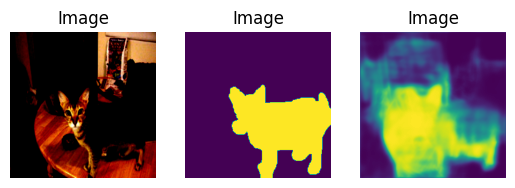

In [26]:
import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.imshow(images[0].cpu().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(labels_test.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(labels_model.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
plt.title("Image")
plt.axis("off")